# Figure 7

Run the steps below to generate the data and plot of Figure 7.

**Lennart van Sluijs** // 2019 Jan 8 // Leiden Observatory // vansluijs@strw.leidenuniv.nl

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from lmfit import minimize, Parameters, Model
from lmfit.models import LinearModel
import numpy as np
from sts_class import SpectralTimeSeries
from matplotlib import pyplot as plt
from aux import tableau20
from astropy import units as u
from astropy import constants as const
import matplotlib.gridspec as gridspec
import os

# Initialize Spectral Time Series
Create a Spectral Time Series from the Beta Pictoris UVES data for the right observation window.

In [2]:
sts = SpectralTimeSeries()
sts.init_from_obs('../data', '../output/figure7/sts_init')
sts.remove_NaN()
sts.save('../output/figure7/sts_data', 'sts')

# Stellar pulsation removal

In [3]:
sts_before = SpectralTimeSeries()
sts_before.load('../output/figure7/sts_data', 'sts')

sts_after = SpectralTimeSeries()
sts_after.load('../output/figure7/sts_data', 'sts')
sts_after.correct_for_pulsations()

# Create plot
First define all functions used to fit Gaussians to the Spectral Time Series and fit linear lines to those.

In [4]:
def line(x, a, b):
    """
    Description:
        Simple linear model.
    Input:
        x - list of x-values
        a - slope
        b - interception with y-axis
    Ouput:
        y(x) - list of line values
    """
    y = a*x+b
    
    return y

def gaussian(x, amp, y0, x0, sigma):
    """
    Description:
        Simple Gaussian function.
    Input:
        x - list of values for which to evaluate the function
        a - amplitude
        y0 - offset in y-direction
        x0 - offset in x-direction
        sigma - standard deviation
    Output:
        y - list of y(x)
    """
    y = amp*np.exp(-(x-x0)**2/(2*sigma**2)) + y0
    
    return y

def get_chisquare(data, model):
    """
    Description:
        Calculate the chi square value.
    Input:
        data - list of datapoints
        model - list of modelpoints
    Output:
        chisquare - value of chisquare
    """
    chisquare = (1./float(len(data))) * np.sum((data - model)/model**2)
    
    return chisquare

def fit_x0(x, y, outputpath = '', plot = True):
    """
    Description:
        Fit a Gaussian profile to the data to get the center.
    Input:
        x - list of x datapoints
        y - list of y(x) datapoints
        outputpath - save plots here
        plot - if True create plots
    Ouput:
        x0 - list of best-fit centroids
        x0_std - list of best-fit standard deviation on centroids
        amp - list of best-fit amplitudes
        amp_std - list of best-fit standard deviation on amplitudes
    """

    # use Gaussian model with inital parameters estimated from the data
    gmodel = Model(gaussian)
    y0 = 1.0
    amp0 = np.max(y) - y0
    x0 = x[np.argmax(y)]
    sigma0 = np.diff(x)[0]
    
    # set bounds
    params = gmodel.make_params(amp=amp0, y0=y0, x0=x0, sigma=sigma0)
    params['x0'].max = np.max(x)
    params['x0'].min = np.min(x)
    params['y0'].vary = True
        
    # fit Gaussian model
    result = gmodel.fit(y + y0, params, x=x)
        
    # get best fit parameters
    x0 = result.params['x0'].value
    x0_std = result.params['x0'].stderr
    amp = result.params['amp'].value
    amp_std = result.params['amp'].stderr
    
    if plot:
        
        # limits
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
        
        # plot figure
        plt.plot(x, y+y0, color = 'k')
        plt.plot(x, result.best_fit, color = tableau20[2], label = 'best fit')
        plt.xlabel('Time [min]', size = 15)
        plt.ylabel('Radial velocity [km/s]', size = 15)
        plt.savefig(os.path.join(outputpath), dpi = 300)
        plt.close()
    
    return x0, x0_std, amp, amp_std

def get_x0_timeseries(data, radvel, time, outputfolder = '', plot = True):
    """
    Description:
        Fit Gaussian function to data to estimate the centroid time series.
    Input:
        data - spectral time series
        radvel - list of radial velocities
        time - list of timestamps
        outputfolder - save plots here if plot = True
        plot - if True create plots to visualize the results
    Ouput:
        x0 - list of best-fit centroids
        x0_std - list of best-fit standard deviation on centroids
        amp - list of best-fit amplitudes
        amp_std - list of best-fit standard deviation on amplitudes
    """

    # get centroid for all spectra
    center = np.zeros(len(time))
    center_std = np.zeros(len(time))
    amp = np.zeros(len(time))
    amp_std = np.zeros(len(time))
    for n in range(len(time)):
        y = data[:, n]
        center[n], center_std[n], \
        amp[n], amp_std[n] = fit_x0(radvel, y,
           outputpath = os.path.join(outputfolder, 'gaussian'+str(n)+'.png'),
           plot = False)
        
    if plot:
        
        # limits
        xmin = 0
        xmax = time[-1]
        ymin = radvel.min()
        ymax = radvel.max()
        ratio = (xmax - xmin)/(ymax - ymin)
        
        # plot figure
        plt.imshow(data, extent = [xmin, xmax, ymin, ymax], aspect = ratio,
                   cmap = 'Greys_r')
        plt.errorbar(time, center, yerr = center_std, color = 'r')
        plt.ylim(ymin, ymax)
        plt.xlabel('Time [min]', size = 15)
        plt.ylabel('Radial velocity [km/s]', size = 15)
        plt.savefig(os.path.join(outputfolder, 'trace.png'), dpi = 300)
        plt.close()
       
    return center, center_std, amp, amp_std
    
def linearfit(x, y, yerr, outputfolder = '', plot = True):
    """
    Description:
        Perform a linear fit on data.
    Input:
        x - list of x-values
        y - list of y(x)
        w - list of weights
        plot - plot if True
    Output:
        out - output of the lmfit procedure
        slope - best-fit of the slope
        slope_sts - best-fit of the standard deviation of the slope
    """
    
    # use linear model with inital parameters estimated from the data
    line_mod = LinearModel()
    params = line_mod.make_params(intercept=y.min(), slope=0)
    
    # fit linear line
    out = line_mod.fit(y, params, x=x, weights = 1./yerr**2,
                       nan_policy='propagate', method = 'leastsq')
    
    # create plot
    if plot:
        dely = out.eval_uncertainty(sigma=1)
        plt.fill_between(x, out.best_fit-dely, out.best_fit+dely,
                         color="#ABABAB")
        plt.errorbar(x, y, yerr = yerr,
                     color = tableau20[0], fmt = 'o', label = 'data')
        plt.plot(x, out.best_fit, 'r-',
                 color = tableau20[2], label = 'best fit')
        plt.legend(loc = 4, frameon = False)
        plt.xlabel('Time [min]', size = 15)
        plt.ylabel('Centroid [km/s]', size = 15)
        plt.savefig(os.path.join(outputfolder, 'linearfit.png'), dpi = 300)
        plt.close()
    
    # slope and uncertainity
    slope = out.params['slope'].value
    slope_std = out.params['slope'].stderr
    redchi = out.redchi
    
    return out, slope, slope_std, redchi
    
def transit_duration(Rs, Rp, a, P, b):
    """
    Description:
        Analytical estimate of the transit duration.
    Input:
        Rs - radius of the star
        Rp - radius of the planet
        a - semi-major axis
        P - orbital period
        b - impact parameter
    Output:
        Tdur - transit duration
    """
    Tdur = P/(np.pi * u.rad) * \
    np.arcsin( np.sqrt( (Rs + Rp)**2 - (b*Rs)**2 )/a )
    
    return Tdur

def a2P(a, Ms):
    """
    Description:
        Convert the semi-major axis into a period using Kepler's third law.
    Input:
        a - semi-major axis
        Ms - stellar mass
    Output:
        P - period of the planet
    """
    P = np.sqrt((4*np.pi**2*a**3)/(const.G * Ms))
    
    return P

def pmin_from_slope(slope, slope_std, time, veq = 130.):
    """
    Description:
        Constrain the exoplanet minimal period
        from the transit duration calculated from the slope.
    Input:
        slope - slope of the exoplanet [km/s / min]
        slope_std - standard deviation of the slope
        time - list of time stamps [min]
        veq - projected rotational velocity of the star [km/s]
    """
    
    # estimate minimal period
    tdurmin = (2.*veq)/(np.abs(slope)+slope_std) * u.min # min
    tdurest = (2.*veq)/(np.abs(slope)) * u.min # min
    tdurmax = (2.*veq)/(np.abs(slope)-slope_std) * u.min # min
        
    # create grid with period versus transit duration
    Rs = 1.8 * u.solRad
    Rp = 1.0 * u.R_jup
    Ms = 1.75 * u.solMass
    b = 0
    a = np.linspace(0.01, 4., 100000) * u.au
    P = a2P(a, Ms)
    Tdur = transit_duration(Rs, Rp, a, P, b)
    
    # plot best minimal period
    fig = plt.figure()
    ax = plt.subplot()
    ax.plot(P.to(u.d).value, Tdur.to(u.h).value, color = tableau20[0])
    ax.axhline(tdurmin.to(u.h).value, color = tableau20[2], label = 'min')
    ax.axhline(tdurest.to(u.h).value, color = tableau20[4], label = 'est')
    ax.axhline(tdurmax.to(u.h).value, color = tableau20[6], label = 'max')
    plt.legend()
    ax.set_xlabel('Period', size = 15)
    ax.set_ylabel('Transit duration', size = 15)
    
    # find optimal period
    pmin = P[np.argmin(np.abs(Tdur.to(u.h).value - tdurmin.to(u.h).value))]
    pest = P[np.argmin(np.abs(Tdur.to(u.h).value - tdurest.to(u.h).value))]
    pmax = P[np.argmin(np.abs(Tdur.to(u.h).value - tdurmax.to(u.h).value))]
    
    print('Delta vrad:')
    print((-slope_std )* time[-1], slope * time[-1],
          (+slope_std) * time[-1])
    print('Period range:')
    print(pmin.to(u.yr)-pest.to(u.yr), pest.to(u.yr),
          pmax.to(u.yr)-pest.to(u.yr))

Secondly, apply the routine and create the plot.

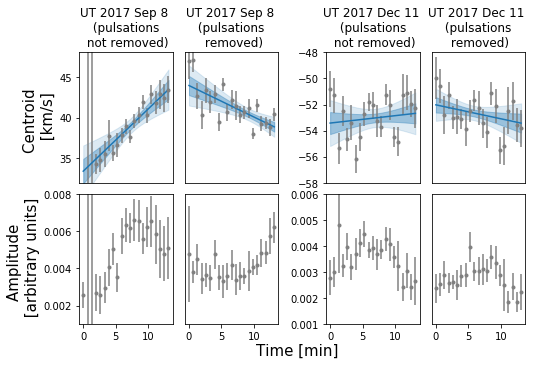

In [5]:
# setup grid for figure
fig = plt.figure(figsize = (8, 5))
gs = gridspec.GridSpec(2, 5, wspace=0.0, hspace=0.085,
                       width_ratios = [1., 1., 0.25, 1., 1.])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[1, 1])

gs.update(wspace=0.15)

ax5 = plt.subplot(gs[0, 3])
ax6 = plt.subplot(gs[1, 3])
ax7 = plt.subplot(gs[0, 4])
ax8 = plt.subplot(gs[1, 4])
ax7.get_yaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)

# first candidate signal - before pulsation removal
obsid = '58004' # epoch observation ID
data = sts_before.datacube[:, sts_before.obsid_dict[obsid]] # data of epoch
center = 86 # index of the candidate signal center in the spectral time series
dw = 10 # used to cut a slice around planet signal
lowlim = center - dw
uplim = center + dw

# cut a slice of the spectral time series around planet signal
x = sts_before.radvel[lowlim:uplim]
data = data[lowlim:uplim, :]

# convert time to minutes and get radial velocities
time = sts_before.time[sts.obsid_dict[obsid]]
time -= time[0]
time *= 24. * 60
radvel = sts_before.radvel[lowlim:uplim]

# get centroid time series by fitting Gaussians to all residual spectra
center, center_std, amp, amp_std = get_x0_timeseries(data, radvel,
                                                     time, '',
                                                     False)

# fit a linear line to the centroid time series
out, slope, slope_std, redchi = linearfit(time, center, center_std, '',
                                                     False)

# create plots of the results of the centroid time series
dely = out.eval_uncertainty(sigma=1)
dely2 = out.eval_uncertainty(sigma=2)
ax1.plot(time, out.best_fit, 'r-', color = tableau20[0], label = 'best fit')
ax1.errorbar(time, center, yerr = center_std, color = 'grey',
             fmt = 'o', ms =3.)
ax1.fill_between(time, out.best_fit-dely, out.best_fit+dely,
                 color= tableau20[0], alpha = 0.35)
ax1.fill_between(time, out.best_fit-dely2, out.best_fit+dely2,
                 color= tableau20[0], alpha = 0.15)
ax1.set_ylabel('Centroid \n [km/s]', size = 15)
ax1.set_title('UT 2017 Sep 8 \n (pulsations \n not removed)', size = 12)
ax1.get_xaxis().set_visible(False)
ax1.set_ylim(32, 48)

# create plots of the results of the amplitude time seris
ax2.errorbar(time, amp, yerr = amp_std, color = 'grey', fmt = 'o', ms =3.)
ax2.set_ylabel('Amplitude \n [arbitrary units]', size = 15)
ax2.set_ylim(0.001, 0.008)

# first candidate signal - after pulsation removal
data = sts_after.datacube[:, sts_after.obsid_dict[obsid]]
x = sts.radvel[lowlim:uplim]
data = data[lowlim:uplim, :]
time = sts.time[sts.obsid_dict[obsid]]
time -= time[0]
time *= 24. * 60
radvel = sts.radvel[lowlim:uplim]

# get centroid time series by fitting Gaussians to all residual spectra
center, center_std, amp, amp_std = get_x0_timeseries(data, radvel,
                                                     time, '',
                                                     False)

# fit a linear line to the centroid time series
out, slope, slope_std, redchi = linearfit(time, center, center_std, '',
                                                     False)

# create plots of the results of the centroid time series
dely = out.eval_uncertainty(sigma=1)
dely2 = out.eval_uncertainty(sigma=2)
ax3.plot(time, out.best_fit, 'r-', color = tableau20[0],
         label = 'best fit')
ax3.errorbar(time, center, yerr = center_std, color = 'grey',
             fmt = 'o', ms =3.)
ax3.fill_between(time, out.best_fit-dely, out.best_fit+dely,
                 color= tableau20[0], alpha = 0.35)
ax3.fill_between(time, out.best_fit-dely2, out.best_fit+dely2,
                 color= tableau20[0], alpha = 0.15)
ax3.set_title('UT 2017 Sep 8 \n (pulsations \n removed)', size = 12)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_ylim(32, 48)

# create plots of the results of the amplitude time seris
ax4.errorbar(time, amp, yerr = amp_std, color = 'grey', fmt = 'o', ms =3.)
ax4.set_ylim(0.001, 0.008)
ax4.get_yaxis().set_visible(False)

# first candidate signal - before pulsation removal
obsid = '58098' # epoch observation ID
data = sts_before.datacube[:, sts_before.obsid_dict[obsid]] # data of epoch
center = 55 # index of the candidate signal center in the spectral time series
dw = 10 # used to cut a slice around planet signal
lowlim = center - dw
uplim = center + dw
x = sts_before.radvel[lowlim:uplim]
data = data[lowlim:uplim, :]
time = sts_before.time[sts.obsid_dict[obsid]]
time -= time[0]
time *= 24. * 60
radvel = sts_before.radvel[lowlim:uplim]

# get centroid time series by fitting Gaussians to all residual spectra
center, center_std, amp, amp_std = get_x0_timeseries(data, radvel,
                                                     time, '',
                                                     False)

# fit a linear line to the centroid time series
out, slope, slope_std, redchi = linearfit(time, center, center_std,
                                          '', False)

# create plots of the results of the centroid time series
dely = out.eval_uncertainty(sigma=1)
dely2 = out.eval_uncertainty(sigma=2)
ax5.plot(time, out.best_fit, 'r-', color = tableau20[0], label = 'best fit')
ax5.errorbar(time, center, yerr = center_std, color = 'grey',
             fmt = 'o', ms =3.)
ax5.fill_between(time, out.best_fit-dely, out.best_fit+dely,
                 color= tableau20[0], alpha = 0.35)
ax5.fill_between(time, out.best_fit-dely2, out.best_fit+dely2,
                 color= tableau20[0], alpha = 0.15)

# create plots of the results of the amplitude time seris
ax5.set_title('UT 2017 Dec 11 \n (pulsations \n not removed)', size = 12)
ax5.get_xaxis().set_visible(False)
ax5.set_ylim(-58, -48)
ax6.errorbar(time, amp, yerr = amp_std, color = 'grey', fmt = 'o', ms =3.)
ax6.set_ylim(0.001, 0.006)

# get data for obsid = '58098'
data = sts_after.datacube[:, sts_after.obsid_dict[obsid]]
center = 55
x = sts_after.radvel[lowlim:uplim]
data = data[lowlim:uplim, :]
time = sts_after.time[sts_after.obsid_dict[obsid]]
time -= time[0]
time *= 24. * 60
radvel = sts_after.radvel[lowlim:uplim]

# get centroid time series by fitting Gaussians to all residual spectra
center, center_std, amp, amp_std = get_x0_timeseries(data, radvel,
                                                     time, '',
                                                     False)

# fit a linear line to the centroid time series
out, slope, slope_std, redchi = linearfit(time, center, center_std, '',
                                                     False)

# create plots of the results of the centroid time series
dely = out.eval_uncertainty(sigma=1)
dely2 = out.eval_uncertainty(sigma=2)
ax7.plot(time, out.best_fit, 'r-', color = tableau20[0], label = 'best fit')
ax7.errorbar(time, center, yerr = center_std, color = 'grey',
             fmt = 'o', ms =3.)
ax7.fill_between(time, out.best_fit-dely, out.best_fit+dely,
                 color= tableau20[0], alpha = 0.35)
ax7.fill_between(time, out.best_fit-dely2, out.best_fit+dely2,
                 color= tableau20[0], alpha = 0.15)
ax7.set_title('UT 2017 Dec 11 \n (pulsations \n removed)', size = 12)
ax7.get_xaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax7.set_ylim(-58, -48)

# create plots of the results of the amplitude time seris
ax8.errorbar(time, amp, yerr=amp_std, color = 'grey', fmt = 'o', ms =3.)
ax8.set_ylim(0.001, 0.006)

# add labels to axes
ax4.annotate('Time [min]', xy = (1.2, -0.2), xycoords='axes fraction',
             va='center', ha='center', fontsize = 15)

# create folder if it does not exist yet
outputfolder = '../output/figure7'
if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)
            
# save the plot
plt.savefig(os.path.join(outputfolder, 'figure7.png'), dpi = 300)
plt.savefig(os.path.join(outputfolder, 'figure7.pdf'))
plt.show()